In [ ]:
!gdown 1seOAJxGY0MxdR90-emKqGFY0ejUcp8tn
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading...
From: https://drive.google.com/uc?id=1seOAJxGY0MxdR90-emKqGFY0ejUcp8tn
To: /content/kaggle.json
100% 69.0/69.0 [00:00<00:00, 340kB/s]


In [ ]:
!kaggle datasets download paramaggarwal/fashion-product-images-dataset

Dataset URL: https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-dataset
License(s): MIT
100% 23.1G/23.1G [02:41<00:00, 214MB/s]
100% 23.1G/23.1G [02:41<00:00, 153MB/s]


In [ ]:
!unzip fashion-product-images-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: fashion-dataset/styles/58128.json  
  inflating: fashion-dataset/styles/58129.json  
  inflating: fashion-dataset/styles/5813.json  
  inflating: fashion-dataset/styles/58131.json  
  inflating: fashion-dataset/styles/58132.json  
  inflating: fashion-dataset/styles/58133.json  
  inflating: fashion-dataset/styles/58135.json  
  inflating: fashion-dataset/styles/58136.json  
  inflating: fashion-dataset/styles/58137.json  
  inflating: fashion-dataset/styles/58138.json  
  inflating: fashion-dataset/styles/58139.json  
  inflating: fashion-dataset/styles/5814.json  
  inflating: fashion-dataset/styles/58140.json  
  inflating: fashion-dataset/styles/58141.json  
  inflating: fashion-dataset/styles/58143.json  
  inflating: fashion-dataset/styles/58144.json  
  inflating: fashion-dataset/styles/58145.json  
  inflating: fashion-dataset/styles/58146.json  
  inflating: fashion-dataset/styles/58147.json  
  inflating: fashion

## Fasion Recommendation System

In [ ]:
!pip install tensorflow
!pip install faiss-gpu
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 24.0 MB/s eta 0:00:00


In [ ]:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D
from sklearn.decomposition import PCA
import faiss  # Install via pip install faiss-gpu
import pickle
from tqdm import tqdm

In [ ]:
# Initialize ResNet50 model
IMG_SIZE = 224  # Optimized image size
BATCH_SIZE = 64  # Process images in batches

In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False
model = Sequential([base_model, GlobalMaxPooling2D()])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Preprocess and batch the dataset using TensorFlow's data pipeline

In [ ]:
def preprocess_image(file_path):
    # Decode the file path from bytes to string
    file_path = file_path.numpy().decode('utf-8')  # Added this line
    img = tf.keras.utils.load_img(file_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.utils.img_to_array(img)
    return preprocess_input(img_array)

def load_dataset(image_dir):
    file_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(lambda x: tf.py_function(func=preprocess_image, inp=[x], Tout=tf.float32), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset, file_paths

# Extract features in batches
def extract_features(dataset, model):
    features = []
    for batch in tqdm(dataset, desc="Extracting Features"):
        batch_features = model.predict(batch, verbose=0)
        features.append(batch_features)
    return np.vstack(features)

## Load dataset and extract features

In [ ]:
image_dir = "fashion-dataset/images"  # Path to your image dataset
dataset, file_paths = load_dataset(image_dir)

In [ ]:
features = extract_features(dataset, model)

Extracting Features: 100%|██████████| 695/695 [04:04<00:00,  2.84it/s]


## Dimensionality reduction with PCA


In [ ]:
pca = PCA(n_components=256)  # Reduce to 256 dimensions
features_pca = pca.fit_transform(features)

## Save the features and file paths


In [ ]:
pickle.dump(features_pca, open("image_features_pca.pkl", "wb"))
pickle.dump(file_paths, open("file_paths.pkl", "wb"))

## Set up FAISS for fast nearest neighbors


### Faiss is a library for efficient similarity search and clustering of dense vectors. It contains algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM. It also contains supporting code for evaluation and parameter tuning. Faiss is written in C++ with complete wrappers for Python/numpy. Some of the most useful algorithms are implemented on the GPU.

In [ ]:
index = faiss.IndexFlatL2(features_pca.shape[1])
features_pca = np.ascontiguousarray(features_pca, dtype=np.float32)  # Ensure the array is C-contiguous and of type float32
faiss.normalize_L2(features_pca)  # Normalize features for cosine similarity
index.add(features_pca)

# Save the FAISS index
faiss.write_index(index, "faiss_index.bin")

## Recommendation Function

In [ ]:
def recommend(image_path, model, index, file_paths, num_results=6):
    # Removed the unnecessary decoding as image_path is already a string
    img = tf.keras.utils.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = tf.keras.utils.img_to_array(img)
    processed_image = preprocess_input(img_array)
    query_features = model.predict(np.expand_dims(processed_image, axis=0))
    query_features_pca = pca.transform(query_features)

    # Ensure query_features_pca is C-contiguous and of type float32
    query_features_pca = np.ascontiguousarray(query_features_pca, dtype=np.float32)

    faiss.normalize_L2(query_features_pca)
    distances, indices = index.search(query_features_pca, num_results)
    recommendations = [file_paths[i] for i in indices[0]]
    return recommendations

## Example Usage


In [ ]:
test_image = "/content/12.png"  # Replace with your query image path
index = faiss.read_index("faiss_index.bin")
recommendations = recommend(test_image, model, index, file_paths)

print("Recommended Images:", recommendations)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Recommended Images: ['fashion-dataset/images/15332.jpg', 'fashion-dataset/images/28626.jpg', 'fashion-dataset/images/28144.jpg', 'fashion-dataset/images/7542.jpg', 'fashion-dataset/images/17925.jpg', 'fashion-dataset/images/13251.jpg']


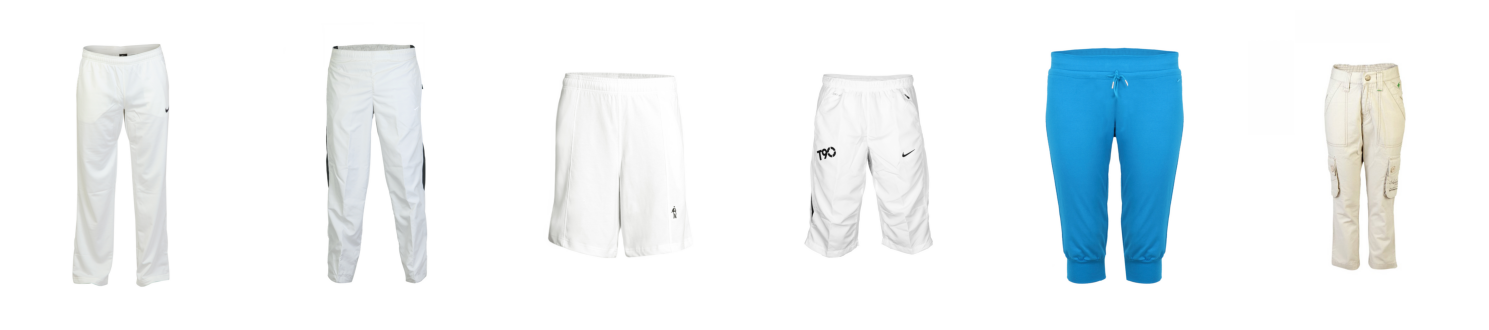

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(1, len(recommendations), figsize=(15, 5)) # Adjust figsize as needed

for i, image_path in enumerate(recommendations):
  try:
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
  except FileNotFoundError:
    print(f"Error: Image file not found at {image_path}")
    axes[i].text(0.5, 0.5, "Image Not Found", ha='center', va='center') # Display message in the subplot
  except Exception as e:
    print(f"An error occurred while displaying the image: {e}")
    axes[i].text(0.5, 0.5, "Error Displaying Image", ha='center', va='center') # Display message in the subplot

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity  # Or any other distance metric
import cv2


def jaccard_similarity(img_path1, img_path2):
    img1 = cv2.imread(img_path1)
    img1 = cv2.resize(img1, (256, 256)) # Adjust size as needed
    pixel_set1 = set(img1.flatten())

    img2 = cv2.imread(img_path2)
    img2 = cv2.resize(img2, (256, 256)) # Adjust size as needed
    pixel_set2 = set(img2.flatten())
    # print(pixel_set1)
    # print(pixel_set2)
    return len(pixel_set1.intersection(pixel_set2)) / len(pixel_set1.union(pixel_set2))


def evaluate_diversity(recommendations):
    # Calculate pairwise Jaccard similarities
    num_recs = len(recommendations)
    similarities = []
    for i in range(num_recs):
        for j in range(i+1, num_recs):
            similarities.append(jaccard_similarity(recommendations[i], recommendations[j])) # Calculate the similarities here.

    # print(similarities)
    average_diversity = 1 - np.mean(similarities) if similarities else 1 # If the list is empty, return 1
    print(np.mean(similarities))
    return average_diversity

# Example usage (assuming you have a list of recommendations)
# print(recommendations)
recommendations_list = recommendations
average_diversity = evaluate_diversity(recommendations_list)
print("Average Diversity:", average_diversity)

0.6839560541977983
Average Diversity: 0.31604394580220174


In [56]:
recommendations = {}
for i in range(1, 11):
  cur_image_path = f"/content/Test Images/{i}.png"  # Replace with your query image path
  index = faiss.read_index("faiss_index.bin")
  recommendations[cur_image_path] = recommend(cur_image_path, model, index, file_paths)

print("Recommended Images:", recommendations)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Recommended Images: {'/content/Test Images/1.png': ['fashion-dataset/images/15620.jpg', 'fashion-dataset/images/15630.jpg', 'fashion-dataset/images/13835.jpg', 'fashion-dataset/images/15321.jpg', 'fashion-dataset/images/15320.jpg', 'fashion-dataset/images/4461.jpg'], '/content/Test Images/2.png': ['fashion-dataset/images/15332.jpg', 'fashion-dataset/images/28626.jpg', 'fashion-dataset/images/28144.jpg', 'fashion-dataset/images/7542.jpg', 'fashion-dataset/images/17925.jpg', 'fashion-dataset/images/13251.jpg'], '/content/Test Images/3.png': ['fashion-dataset/images/18681.jpg', 'fashion-dataset/images/28075.jpg', 'f

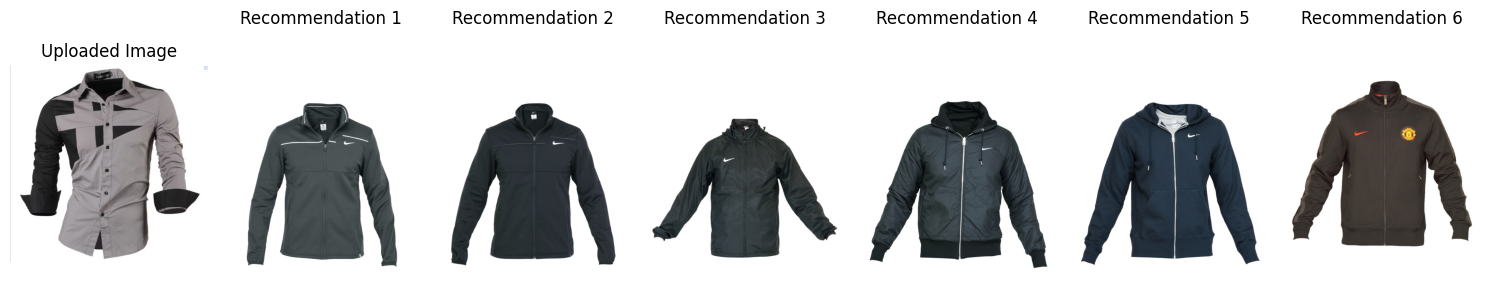

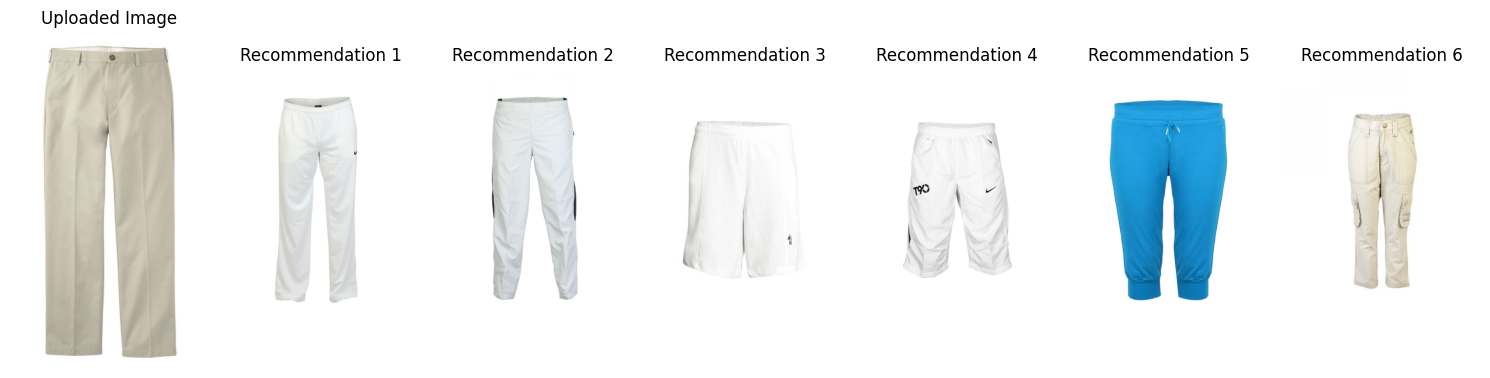

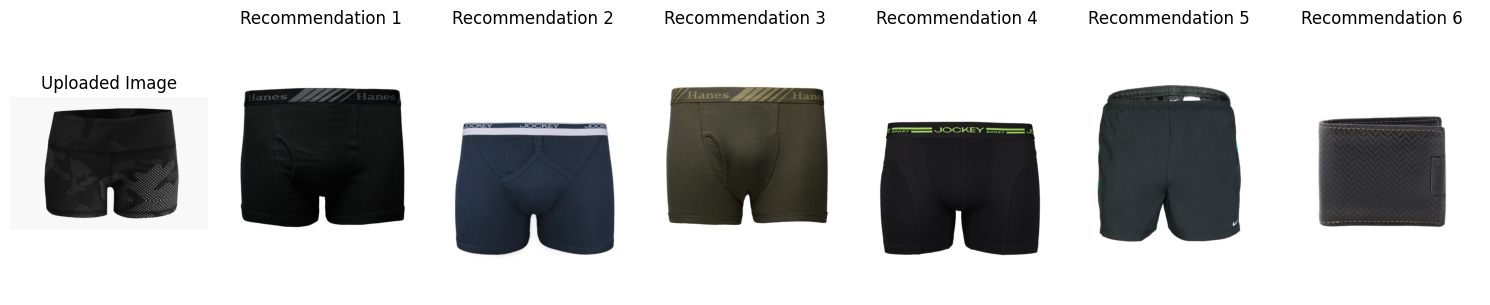

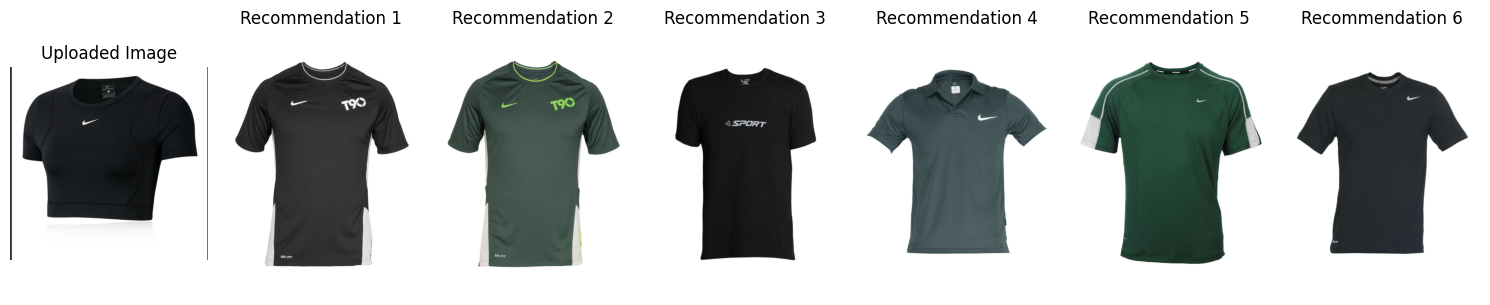

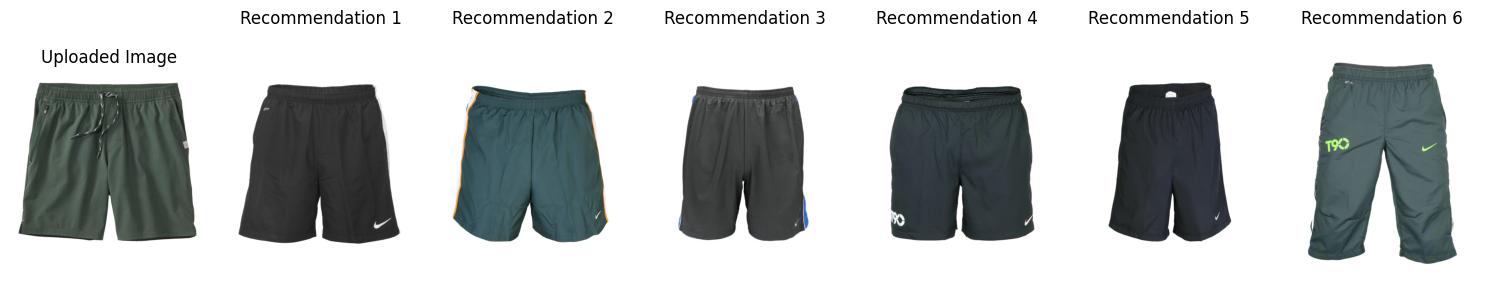

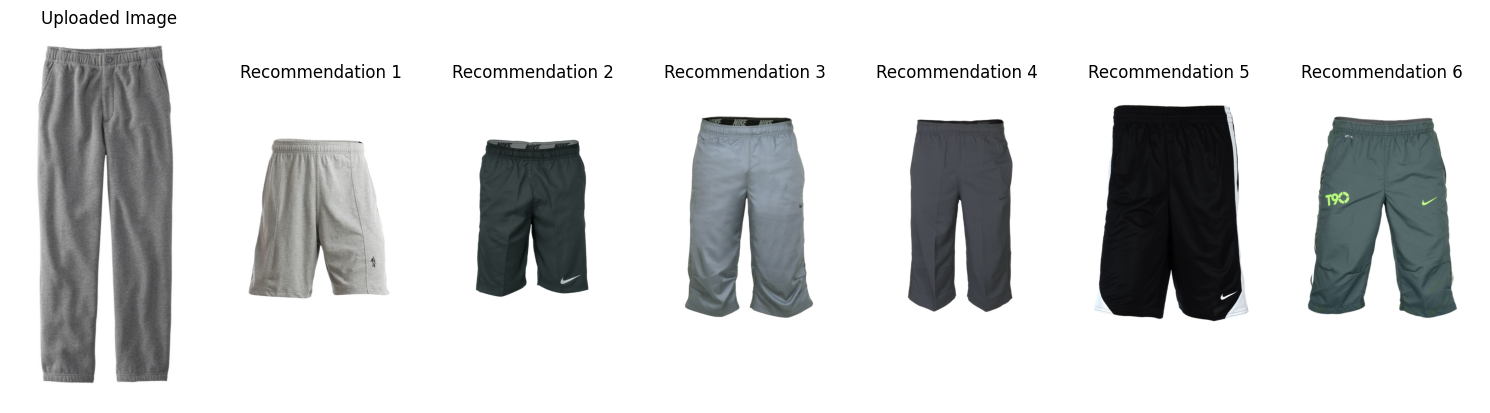

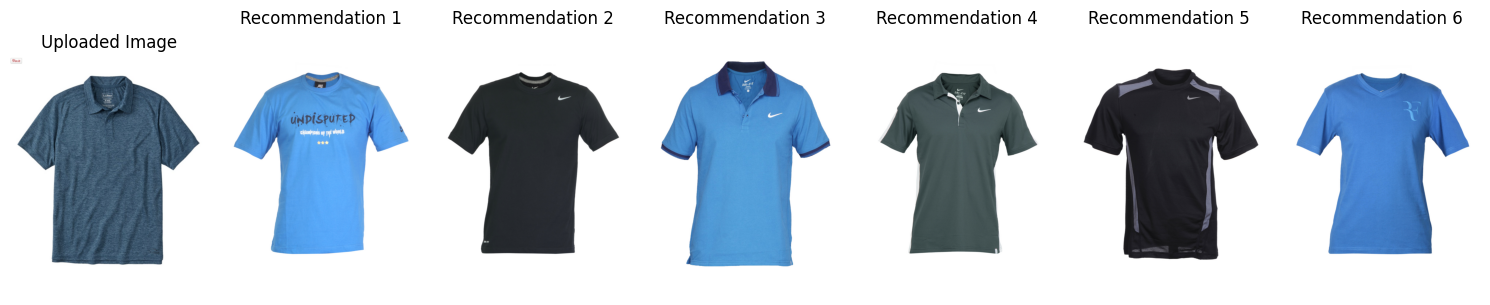

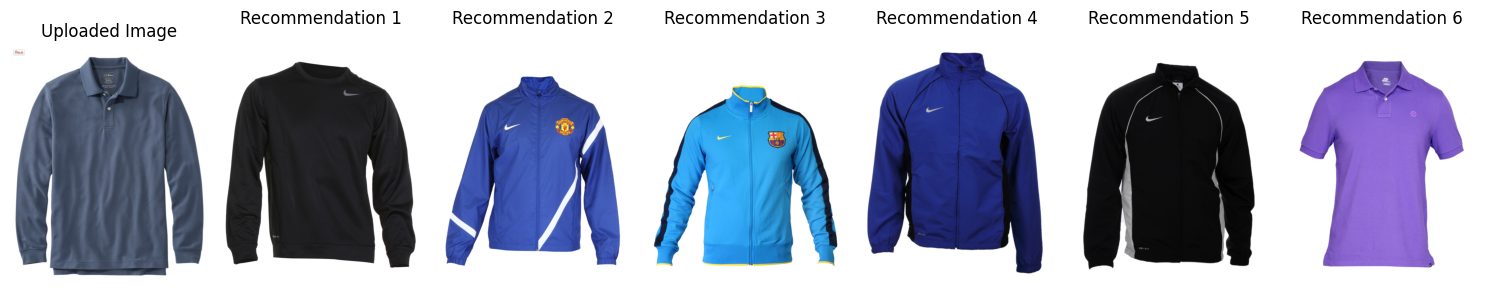

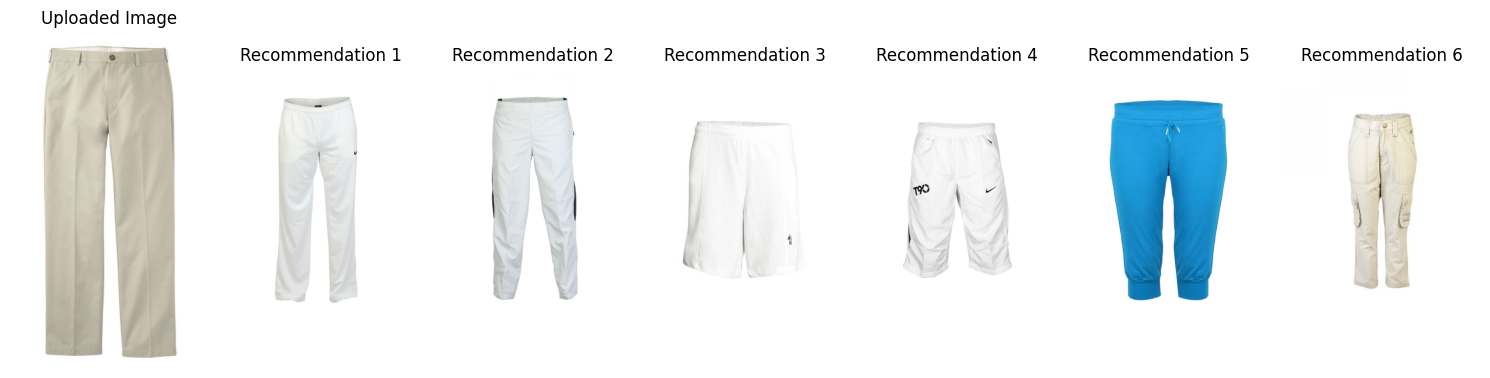

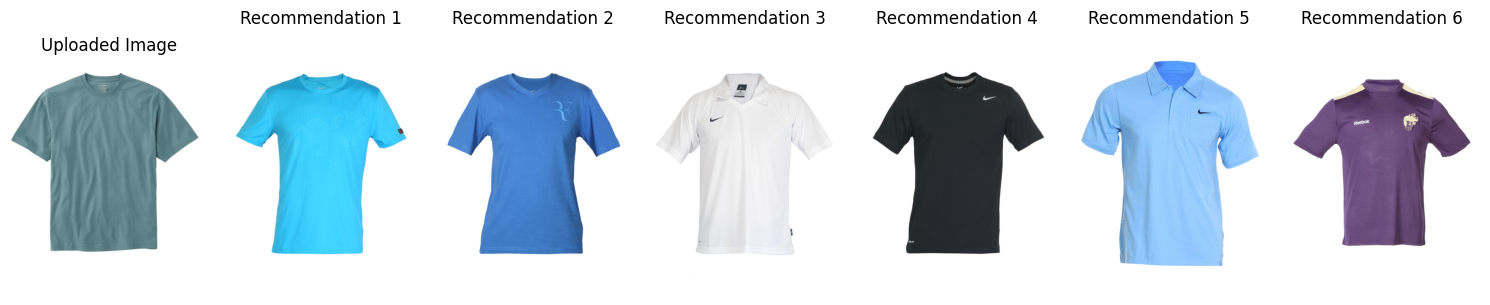

In [70]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def plot_recommendations(recommendations):
    """Plots the uploaded image and its recommended images.

    Args:
        recommendations (dict): A dictionary where keys are uploaded image paths
                               and values are lists of recommended image paths.
    """
    for uploaded_image, recommended_images in recommendations.items():
        num_recommendations = len(recommended_images)
        fig, axes = plt.subplots(1, num_recommendations + 1, figsize=(15, 5))

        # Plot the uploaded image
        try:
            img = mpimg.imread(uploaded_image)
            axes[0].imshow(img)
            axes[0].set_title("Uploaded Image")
            axes[0].axis('off')
        except FileNotFoundError:
            print(f"Error: Uploaded image file not found at {uploaded_image}")
            axes[0].text(0.5, 0.5, "Image Not Found", ha='center', va='center')
        except Exception as e:
            print(f"An error occurred while displaying the uploaded image: {e}")
            axes[0].text(0.5, 0.5, "Error Displaying Image", ha='center', va='center')


        # Plot the recommended images
        for i, image_path in enumerate(recommended_images):
            try:
                img = mpimg.imread(image_path)
                axes[i+1].imshow(img)
                axes[i+1].set_title(f"Recommendation {i+1}")
                axes[i+1].axis('off')
            except FileNotFoundError:
                print(f"Error: Image file not found at {image_path}")
                axes[i+1].text(0.5, 0.5, "Image Not Found", ha='center', va='center')
            except Exception as e:
                print(f"An error occurred while displaying the image: {e}")
                axes[i+1].text(0.5, 0.5, "Error Displaying Image", ha='center', va='center')

        plt.tight_layout()
        plt.show()

# Example usage (assuming 'recommendations' is defined as in your code)
plot_recommendations(recommendations)

0.9913734737661469
0.6839560541977983
0.9526739487027659
0.9651436044284366
0.9128674904805664
0.9495639008605837
0.9534043633372223
0.9874928513071896
0.6839560541977983
0.9152111363731412


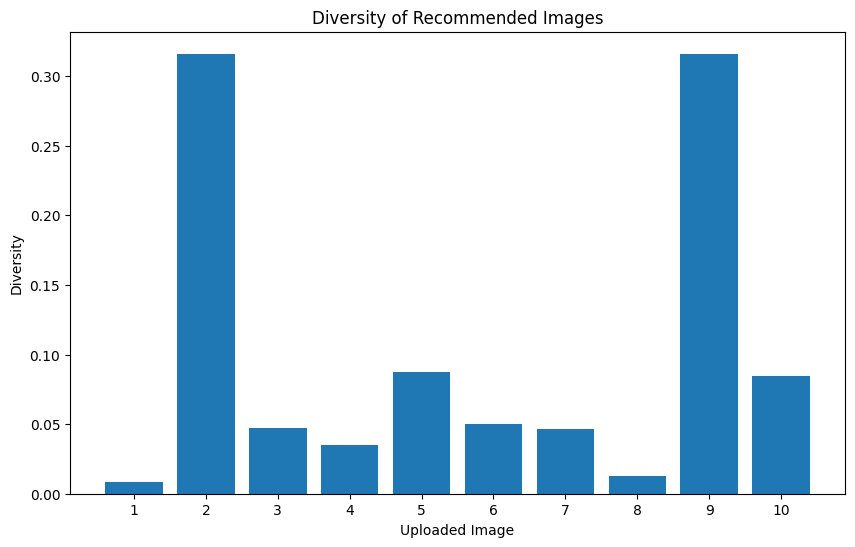

In [71]:
# prompt: plot diversity of the recommendated images

import matplotlib.pyplot as plt

def plot_diversity(recommendations):
    diversities = []
    for uploaded_image, recommended_images in recommendations.items():
        diversity = evaluate_diversity(recommended_images)
        diversities.append(diversity)

    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(recommendations) + 1), diversities)
    plt.xlabel("Uploaded Image")
    plt.ylabel("Diversity")
    plt.title("Diversity of Recommended Images")
    plt.xticks(range(1, len(recommendations) + 1))  # Set x-axis ticks
    plt.show()

plot_diversity(recommendations)